In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, ward_tree
from sklearn.metrics import plot_confusion_matrix, accuracy_score, mean_squared_error
from sklearn.naive_bayes import GaussianNB
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

# Aquisição dos dados

|Country|Index|Ticker|
|---        |---        |---        |
|Brazil|iBovespa|^BVSP|
|USA|Nasdaq Composite|^IXIC|
|USA|NYSE Composite|^NYA|
|USA|Dow Jones|^DJI|
|Argentina|Merval|M.BA|
|Japan|Nikkei 225|^N225|
|China|Shangai Composite|000001.SS|
|China|Hang Seng|^HSI|
|India|BSE 30 Sensex|^BSESN|
|UK|FTSE 100|^FTSE|
|Sweden|Stockholm General|^OMX|
|Germany|Dax|^GDAXI|
|France|Cac 40|^FCHI|

In [48]:
start_date = "2011-01-01"
end_date = "2021-05-31"

df_ibovespa = yf.download('^BVSP', start=start_date, end=end_date)

# Indices de bolsas:
# ^BVSP
# ^IXIC
# ^NYA
# ^DJI
# M.BA
# ^N225
# 000001.SS
# ^HSI
# ^BSESN
# ^FTSE
# ^OMX
# ^GDAXI
# ^FCHI


[*********************100%***********************]  1 of 1 completed


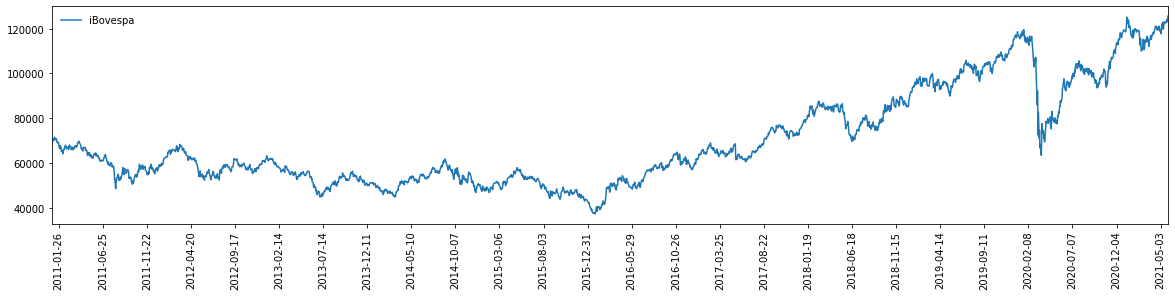

In [5]:
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(111)

ax.plot(df_ibovespa['Close'], label="iBovespa")

date_min = df_ibovespa.index.min()
date_max = df_ibovespa.index.max()
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
ax.set_xlim(left=date_min, right=date_max)

ax.legend(loc='upper left', frameon=False)
plt.xticks(rotation=90)
plt.show();

## Preparação dos dados

Nesta seção, tomaremos as seguintes ações:

1. Separação do conjunto de dados de treinamento (01/01/2011 até 30/04/2021) e de validação do modelo (01/05/2021 até 30/05/2021).
1. Criação do atributo **"p/e"**: $ p/e = 100*(ln({r_{t}}) - ln({r_{t-1}})) $.
1. Criação da resposta **cluster** usando apenas a simples separação. Lembrando que no artigo, os autores compararam duas abordagens diferentes para discretizar a resposta ((a) simples separação e (b) Ward).

In [6]:
X_train = df_ibovespa[:"2021-05-01"]
X_test = df_ibovespa["2021-05-01":]

print(f"""Base original: {df_ibovespa.shape}
X_train: {X_train.shape}
X_test: {X_test.shape}\n""")

X_train["rt"] = (np.log(X_train["Close"]) - np.log(X_train["Close"].shift(periods=1)))*100
X_train = X_train[["Close", "rt"]][1:]
X_train.head()

Base original: (2570, 6)
X_train: (2550, 6)
X_test: (20, 6)



Close        rt
Date                         
2011-01-04  70318.0  0.507557
2011-01-05  71091.0  1.093293
2011-01-06  70579.0 -0.722810
2011-01-07  70057.0 -0.742345
2011-01-10  70127.0  0.099869

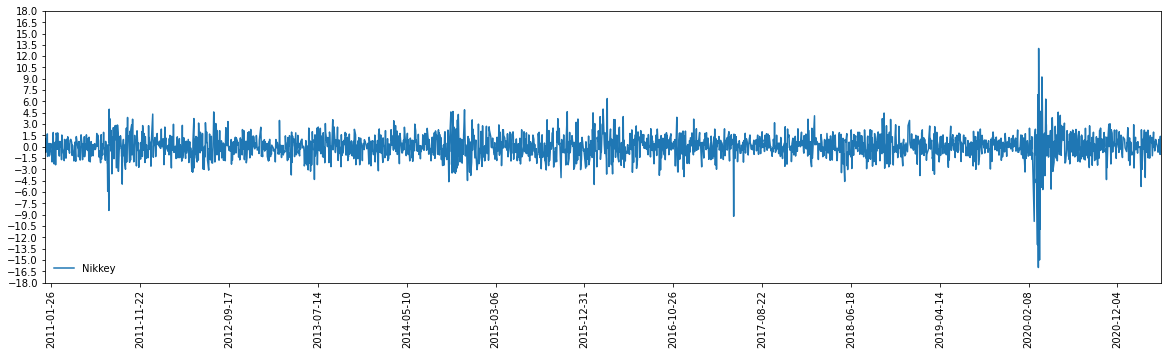

In [7]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)

date_min = X_train.index.min()
date_max = X_train.index.max()

ax.plot(X_train['rt'], label="Nikkey")

ax.xaxis.set_major_locator(plt.MaxNLocator(13))
ax.yaxis.set_major_locator(plt.MaxNLocator(30))
ax.set_ylim(-18, 18)
ax.set_xlim(left=date_min, right=date_max)

ax.legend(loc='lower left', frameon=False)
plt.xticks(rotation=90)
plt.show();

count    2549.000000
mean        0.020803
std         1.623617
min       -15.993027
25%        -0.827695
50%         0.028816
75%         0.907887
max        13.022281
Name: rt, dtype: float64

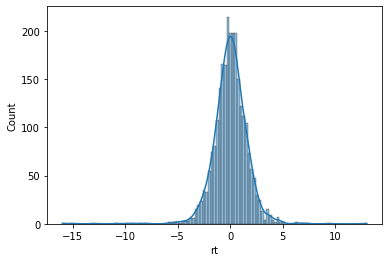

In [15]:
sns.histplot(data=X_train, x="rt", kde=True);
X_train['rt'].describe().T

### Agrupamento dos $r_{t}$

**Agrupamentos uniformes**

In [16]:
def uniform_clustering(df: pd.DataFrame, lst_columns: list) -> pd.DataFrame:
    """This function creates the target "Cluster" according to the limits described in article."""
    for column in lst_columns:
        desc = X_train['rt'].describe().T
        conditions  = [
            df[column] < desc["25%"],
            (df[column] >= desc["25%"]) & (df[column] < 0),
            (df[column] >= 0) & (df[column] < desc["75%"]),
            (df[column] >= desc["75%"])]
        # choices = [ "C1", "C2", "C3", "C4", "C5", "C6"]
        choices = [ 1, 2, 3, 4]
        df["cluster_"+column] = np.select(conditions, choices, default=np.nan)

    return df

In [17]:
X_train = uniform_clustering(X_train, ["rt"])

X_train.head()

Close        rt  cluster_rt
Date                                     
2011-01-04  70318.0  0.507557         3.0
2011-01-05  71091.0  1.093293         4.0
2011-01-06  70579.0 -0.722810         2.0
2011-01-07  70057.0 -0.742345         2.0
2011-01-10  70127.0  0.099869         3.0

In [18]:
round(X_train.groupby(by=["cluster_rt"]).agg({"rt": ["min", "max","count", "mean"]}), 2).reset_index()

cluster_rt     rt                   
                min    max count  mean
0        1.0 -15.99  -0.83   637 -1.88
1        2.0  -0.83  -0.00   611 -0.39
2        3.0   0.00   0.91   663  0.43
3        4.0   0.91  13.02   638  1.88

In [20]:
def create_shifted_rt(df: pd.DataFrame, rts: list) -> pd.DataFrame:
    for t in rts:
        df[f"rt-{t}"] = df["rt"].shift(periods=t)
    return df

In [23]:
X_train = df_ibovespa.loc[:"2021-05-01", ["Close"]]
X_test = df_ibovespa.loc["2021-05-01":, ["Close"]]

X_train["rt"] = (np.log(X_train["Close"]) - np.log(X_train["Close"].shift(periods=1)))*100
X_train = create_shifted_rt(X_train, [1, 5, 37])
X_train = uniform_clustering(X_train, ["rt", "rt-1", "rt-5", "rt-37"])

X_train.dropna(how='any', axis=0, inplace=True)
# X_train = X_train[["cluster_rt", "cluster_rt-1", "cluster_rt-5", "cluster_rt-37"]]
X_train.head(10)

Close        rt      rt-1      rt-5     rt-37  cluster_rt  \
Date                                                                      
2011-02-25  66903.0 -0.068733  0.058270  0.562792  0.507557         2.0   
2011-02-28  67383.0  0.714895 -0.068733 -1.194168  1.093293         3.0   
2011-03-01  66243.0 -1.706296  0.714895 -1.225155 -0.722810         1.0   
2011-03-02  67282.0  1.556294 -1.706296  0.704915 -0.742345         4.0   
2011-03-03  68146.0  1.275972  1.556294  0.058270  0.099869         4.0   
2011-03-04  68012.0 -0.196830  1.275972 -0.068733  0.421203         2.0   
2011-03-09  67264.0 -1.105898 -0.196830  0.714895  1.703595         1.0   
2011-03-10  66041.0 -1.834941 -1.105898 -1.706296 -1.281330         1.0   
2011-03-11  66685.0  0.970428 -1.834941  1.556294  0.309189         4.0   
2011-03-14  67169.0  0.723179  0.970428  1.275972 -0.467683         3.0   

            cluster_rt-1  cluster_rt-5  cluster_rt-37  
Date                                                   
2011-02-25           3.0           3.0            3.0  
2011-02-28           2.0           1.0            4.0  
2011-03-01           3.0           1.0            2.0  
2011-03-02           1.0           3.0            2.0  
2011-03-03           4.0           3.0            3.0  
2011-03-04           4.0           2.0            3.0  
2011-03-09           2.0           3.0            4.0  
2011-03-10           1.0           1.0            1.0  
2011-03-11           1.0           4.0            3.0  
2011-03-14           4.0           4.0            2.0

### Preparando conjunto de validação


In [26]:
X_test = df_ibovespa.loc["2021-01-01":, ["Close"]]

X_test["rt"] = (np.log(X_test["Close"]) - np.log(X_test["Close"].shift(periods=1)))*100
X_test = create_shifted_rt(X_test, [1, 5, 37])
X_test = uniform_clustering(X_test, ["rt", "rt-1", "rt-5", "rt-37"])


X_test = X_test["2021-05-01":]
X_test.head(10)


Close        rt      rt-1      rt-5     rt-37  cluster_rt  \
Date                                                                       
2021-05-03  119209.0  0.264592 -0.980925  0.053914  0.647916         3.0   
2021-05-04  117712.0 -1.263729  0.264592 -1.005913  1.289580         1.0   
2021-05-05  119564.0  1.561083 -1.263729  1.384977  1.938944         4.0   
2021-05-06  119921.0  0.298140  1.561083 -0.818687 -0.719202         3.0   
2021-05-07  122038.0  1.749928  0.298140 -0.980925  0.603466         4.0   
2021-05-10  121909.0 -0.105761  1.749928  0.264592 -0.727053         2.0   
2021-05-11  122964.0  0.861676 -0.105761 -1.263729  2.194668         3.0   
2021-05-12  119710.0 -2.681948  0.861676  1.561083 -1.481547         1.0   
2021-05-13  120706.0  0.828569 -2.681948  0.298140  1.200584         3.0   
2021-05-14  121881.0  0.968732  0.828569  1.749928 -1.075265         4.0   

            cluster_rt-1  cluster_rt-5  cluster_rt-37  
Date                                                   
2021-05-03           1.0           3.0            3.0  
2021-05-04           3.0           1.0            4.0  
2021-05-05           1.0           4.0            4.0  
2021-05-06           4.0           2.0            2.0  
2021-05-07           3.0           1.0            3.0  
2021-05-10           4.0           3.0            2.0  
2021-05-11           2.0           1.0            4.0  
2021-05-12           3.0           4.0            1.0  
2021-05-13           1.0           3.0            4.0  
2021-05-14           3.0           4.0            1.0

## Treinando um modelo

Vamos testar primeiro um Naive Bayes:

In [27]:
model = GaussianNB()
model.fit(X_train[["rt-1", "rt-5", "rt-37"]], X_train["cluster_rt"])

GaussianNB()

### Prevendo e avaliando preliminarmente

Primeiro, vamos ver como fica a acurácia e a proporção de acertos por classe.

In [29]:
y_pred = model.predict(X_test[["rt-1", "rt-5", "rt-37"]])
X_test_ = X_test.copy()
# X_test_ = X_test_[["rt", "rt-1", "rt-5", "rt-37"]]
X_test_["y_pred"] = y_pred

X_test_

Close        rt      rt-1      rt-5     rt-37  cluster_rt  \
Date                                                                       
2021-05-03  119209.0  0.264592 -0.980925  0.053914  0.647916         3.0   
2021-05-04  117712.0 -1.263729  0.264592 -1.005913  1.289580         1.0   
2021-05-05  119564.0  1.561083 -1.263729  1.384977  1.938944         4.0   
2021-05-06  119921.0  0.298140  1.561083 -0.818687 -0.719202         3.0   
2021-05-07  122038.0  1.749928  0.298140 -0.980925  0.603466         4.0   
2021-05-10  121909.0 -0.105761  1.749928  0.264592 -0.727053         2.0   
2021-05-11  122964.0  0.861676 -0.105761 -1.263729  2.194668         3.0   
2021-05-12  119710.0 -2.681948  0.861676  1.561083 -1.481547         1.0   
2021-05-13  120706.0  0.828569 -2.681948  0.298140  1.200584         3.0   
2021-05-14  121881.0  0.968732  0.828569  1.749928 -1.075265         4.0   
2021-05-17  122938.0  0.863500  0.968732 -0.105761 -1.504578         3.0   
2021-05-18  122980.0  0.034158  0.863500  0.861676 -1.063358         3.0   
2021-05-19  122636.0 -0.280112  0.034158 -2.681948  1.493292         2.0   
2021-05-20  122701.0  0.052988 -0.280112  0.828569  0.902291         3.0   
2021-05-21  122592.0 -0.088873  0.052988  0.968732  0.554302         2.0   
2021-05-24  124032.0  1.167783 -0.088873  0.863500  1.232208         4.0   
2021-05-25  122988.0 -0.845281  1.167783  0.034158 -0.185023         1.0   
2021-05-26  123989.0  0.810606 -0.845281 -0.280112 -1.191111         3.0   
2021-05-27  124367.0  0.304402  0.810606  0.052988  1.946180         3.0   
2021-05-28  125561.0  0.955482  0.304402 -0.088873 -0.016169         4.0   

            cluster_rt-1  cluster_rt-5  cluster_rt-37  y_pred  
Date                                                           
2021-05-03           1.0           3.0            3.0     3.0  
2021-05-04           3.0           1.0            4.0     2.0  
2021-05-05           1.0           4.0            4.0     2.0  
2021-05-06           4.0           2.0            2.0     3.0  
2021-05-07           3.0           1.0            3.0     3.0  
2021-05-10           4.0           3.0            2.0     3.0  
2021-05-11           2.0           1.0            4.0     2.0  
2021-05-12           3.0           4.0            1.0     3.0  
2021-05-13           1.0           3.0            4.0     4.0  
2021-05-14           3.0           4.0            1.0     3.0  
2021-05-17           4.0           2.0            1.0     3.0  
2021-05-18           3.0           3.0            1.0     3.0  
2021-05-19           3.0           1.0            4.0     1.0  
2021-05-20           2.0           3.0            3.0     3.0  
2021-05-21           3.0           4.0            3.0     3.0  
2021-05-24           2.0           3.0            4.0     2.0  
2021-05-25           4.0           3.0            2.0     3.0  
2021-05-26           1.0           2.0            1.0     3.0  
2021-05-27           3.0           3.0            4.0     2.0  
2021-05-28           3.0           2.0            2.0     3.0

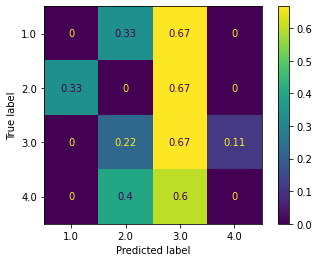

In [30]:
plot_confusion_matrix(model, X_test_[["rt-1", "rt-5", "rt-37"]], X_test_["cluster_rt"], normalize='true');

In [31]:
accuracy_score(X_test_["cluster_rt"], y_pred, normalize=True)

0.3

In [36]:
rt_mean = round(X_train.groupby(by=["cluster_rt"]).agg({"rt": ["min", "max","count", "mean"]}), 2)[("rt", "mean")]

conditions = [X_test_["y_pred"]==1.0, X_test_["y_pred"]==2.0, X_test_["y_pred"]==3.0, X_test_["y_pred"]==4.0]
choices = rt_mean.tolist()
X_test_["rt_predict"] = np.select(conditions, choices, default=np.nan)

rmse_uniform = mean_squared_error(X_test_["rt"], X_test_["rt_predict"], squared=False)
print(f"RMSE para esse método: {round(rmse_uniform, 4)}%")

RMSE para esse método: 1.1744%


## Achando a estrutura da rede

In [42]:
sequencia = np.arange(2, 10, 2)
# sequencia = [1,5,37]
sequencia_rt = list(["rt-"+str(_) for _ in sequencia][::-1])
sequencia_rt.append('rt')

print(f"""\nTamanho da sequência: {len(sequencia)}
Sequência: {sequencia_rt}""")


Tamanho da sequência: 4
Sequência: ['rt-8', 'rt-6', 'rt-4', 'rt-2', 'rt']


In [43]:
X_train_network = X_train[["rt"]].copy()
X_train_network = create_shifted_rt(X_train_network, sequencia)
X_train_network = uniform_clustering(X_train_network, sequencia_rt)

X_train_network.dropna(how="any", axis=0, inplace=True)
X_train_network = X_train_network.sample(100, random_state=0).copy()
# X_train_network = X_train_network.iloc[-10:,]
X_train_network = X_train_network[[column for column in X_train_network.columns if 'cluster_' in column]]

print(f"Tamanho: {X_train_network.shape}")

X_train_network.tail(10)

Tamanho: (100, 5)


cluster_rt-8  cluster_rt-6  cluster_rt-4  cluster_rt-2  cluster_rt
Date                                                                          
2019-09-23           3.0           1.0           3.0           2.0         2.0
2017-12-07           2.0           1.0           3.0           2.0         1.0
2020-01-08           3.0           2.0           4.0           2.0         2.0
2018-09-11           4.0           3.0           1.0           4.0         1.0
2018-01-26           3.0           2.0           3.0           4.0         4.0
2017-03-14           1.0           2.0           1.0           3.0         1.0
2018-05-23           2.0           2.0           1.0           1.0         1.0
2018-07-24           4.0           3.0           1.0           4.0         4.0
2013-01-16           1.0           1.0           3.0           4.0         3.0
2018-05-28           4.0           2.0           4.0           1.0         1.0

In [44]:
from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch, K2Score, BicScore
from pgmpy.utils import get_example_model
from pgmpy.sampling import BayesianModelSampling

bic = BicScore(X_train_network)
k2 = K2Score(X_train_network)

scoring_method = bic

serch_method =  "ExhaustiveSearch" # or "HillClimbSearch"

if serch_method == "ExhaustiveSearch":
    es = ExhaustiveSearch(X_train_network, scoring_method=scoring_method)
    best_model = es.estimate()

    print("All DAGs by score:")
    for score, dag in reversed(es.all_scores()):
        if (len(dag.edges()) >= 3): # and ("cluster_rt" in dag.edges())
            print(score, dag.edges())
        # print(score, len(dag.edges()))
        # print(score, dag.edges())
else:
    es = HillClimbSearch(X_train_network, scoring_method=scoring_method)
    best_model = es.estimate(max_indegree=3, scoring_method=scoring_method, max_iter=100)

    for combination in best_model.edges():
        print(combination)


), ('cluster_rt', 'cluster_rt-6'), ('cluster_rt-4', 'cluster_rt-6'), ('cluster_rt-2', 'cluster_rt-4'), ('cluster_rt-2', 'cluster_rt-6'), ('cluster_rt-8', 'cluster_rt'), ('cluster_rt-8', 'cluster_rt-2'), ('cluster_rt-8', 'cluster_rt-4'), ('cluster_rt-8', 'cluster_rt-6')]
-2744.7777828043995 [('cluster_rt', 'cluster_rt-2'), ('cluster_rt', 'cluster_rt-4'), ('cluster_rt', 'cluster_rt-8'), ('cluster_rt-4', 'cluster_rt-6'), ('cluster_rt-4', 'cluster_rt-8'), ('cluster_rt-4', 'cluster_rt-2'), ('cluster_rt-8', 'cluster_rt-2'), ('cluster_rt-6', 'cluster_rt-8'), ('cluster_rt-6', 'cluster_rt-2')]
-2744.7777828043995 [('cluster_rt', 'cluster_rt-2'), ('cluster_rt', 'cluster_rt-4'), ('cluster_rt', 'cluster_rt-8'), ('cluster_rt-2', 'cluster_rt-8'), ('cluster_rt-4', 'cluster_rt-6'), ('cluster_rt-4', 'cluster_rt-8'), ('cluster_rt-4', 'cluster_rt-2'), ('cluster_rt-6', 'cluster_rt-8'), ('cluster_rt-6', 'cluster_rt-2')]
-2744.7777828044 [('cluster_rt', 'cluster_rt-2'), ('cluster_rt', 'cluster_rt-8'), ('clu

In [46]:
for score, dag in reversed(es.all_scores()):
    if (len(dag.edges()) >= 3): # and ("cluster_rt" in dag.edges())
        print(score, dag.edges())

-764.981046150885 [('cluster_rt', 'cluster_rt-8'), ('cluster_rt-4', 'cluster_rt'), ('cluster_rt-6', 'cluster_rt-2')]
-764.981046150885 [('cluster_rt', 'cluster_rt-8'), ('cluster_rt-2', 'cluster_rt-6'), ('cluster_rt-4', 'cluster_rt')]
-764.981046150885 [('cluster_rt', 'cluster_rt-4'), ('cluster_rt-8', 'cluster_rt'), ('cluster_rt-6', 'cluster_rt-2')]
-764.981046150885 [('cluster_rt', 'cluster_rt-4'), ('cluster_rt-2', 'cluster_rt-6'), ('cluster_rt-8', 'cluster_rt')]
-764.981046150885 [('cluster_rt', 'cluster_rt-4'), ('cluster_rt', 'cluster_rt-8'), ('cluster_rt-6', 'cluster_rt-2')]
-764.981046150885 [('cluster_rt', 'cluster_rt-4'), ('cluster_rt', 'cluster_rt-8'), ('cluster_rt-2', 'cluster_rt-6')]
-765.4799243933171 [('cluster_rt', 'cluster_rt-8'), ('cluster_rt-4', 'cluster_rt'), ('cluster_rt-6', 'cluster_rt-4')]
-765.4799243933171 [('cluster_rt', 'cluster_rt-8'), ('cluster_rt-4', 'cluster_rt-6'), ('cluster_rt-4', 'cluster_rt')]
-765.4799243933171 [('cluster_rt', 'cluster_rt-4'), ('cluster_

Usar a busca exaustiva para mais de 5 nós é muito exaustivo....